# Notebook 2: Baseline Model Training (Isolation Forest)

### Objective
The purpose of this notebook is to train, evaluate, and save a baseline anomaly detection model. We will use the `IsolationForest` algorithm from scikit-learn as our first model.

### Why Isolation Forest?
Isolation Forest is an excellent choice for a baseline model because it is computationally efficient and performs well on this type of "obvious spike" anomaly. It is an unsupervised algorithm that works by "isolating" observations, and it inherently identifies anomalies as data points that are easier to separate from the rest of the sample.

### Key Steps
1.  **Setup**: Import libraries and configure paths.
2.  **Data Loading**: Load the prepared dataset.
3.  **Feature Selection**: Select the feature(s) to be used for training.
4.  **Model Training**: Train the `IsolationForest` model.
5.  **Evaluation**: Evaluate the model's performance against our known labels.
6.  **Model Serialization**: Save the trained model to a file for later use in our API.

### Expected Outcome
A trained `IsolationForest` model saved as a `.joblib` file and a performance report detailing its effectiveness at identifying the anomalies in our dataset.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 6)

# --- Path Configuration ---
BASE_DIR = ".."
DATA_ROOT_DIR = os.path.join(BASE_DIR, "data/raw/NAB-master")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

# --- Dataset Selection (consistent with Notebook 1) ---
DATASET_NAME = "realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
LABELS_FILE = "labels/combined_labels.json"

data_path = os.path.join(DATA_ROOT_DIR, "data", DATASET_NAME)
label_path = os.path.join(DATA_ROOT_DIR, LABELS_FILE)

print("Configuration completed")

Configuration completed


## Data Loading and Preparation

We will repeat the core data loading and preparation steps to ensure this notebook can be run independently. We load the time-series data and integrate the pre-verified anomaly labels.

In [2]:
# Load the dataset
df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')

# Load the labels JSON
with open(label_path, 'r') as f:
    labels = json.load(f)

# Integrate labels into the DataFrame
anomaly_timestamp_strings = labels.get(DATASET_NAME, [])
anomaly_datetimes = pd.to_datetime(anomaly_timestamp_strings)
df['is_anomaly'] = 0
anomalies_in_df_index = df.index.intersection(anomaly_datetimes)
df.loc[anomalies_in_df_index, 'is_anomaly'] = 1

print("Data loaded and prepared.")
print("Anomaly counts:")
print(df['is_anomaly'].value_counts())
display(df.head())

Data loaded and prepared.
Anomaly counts:
is_anomaly
0    4030
1       2
Name: count, dtype: int64


,value,is_anomaly
timestamp,,
2014-02-14 14:30:00,0.132,0
2014-02-14 14:35:00,0.134,0
2014-02-14 14:40:00,0.134,0
2014-02-14 14:45:00,0.134,0
2014-02-14 14:50:00,0.134,0


## 1.1 Deep Dive into Normal Data Distribution

Given the model's high sensitivity in the API, we need to take a closer look at the statistical distribution of the normal data points it was trained on. We will compute descriptive statistics and plot a histogram to understand what the model learned as "normal".

--- Descriptive Statistics for NORMAL data points ---


count    4030.000000
mean        0.125635
std         0.087844
min         0.066000
25%         0.132000
50%         0.134000
75%         0.134000
max         1.600000
Name: value, dtype: float64

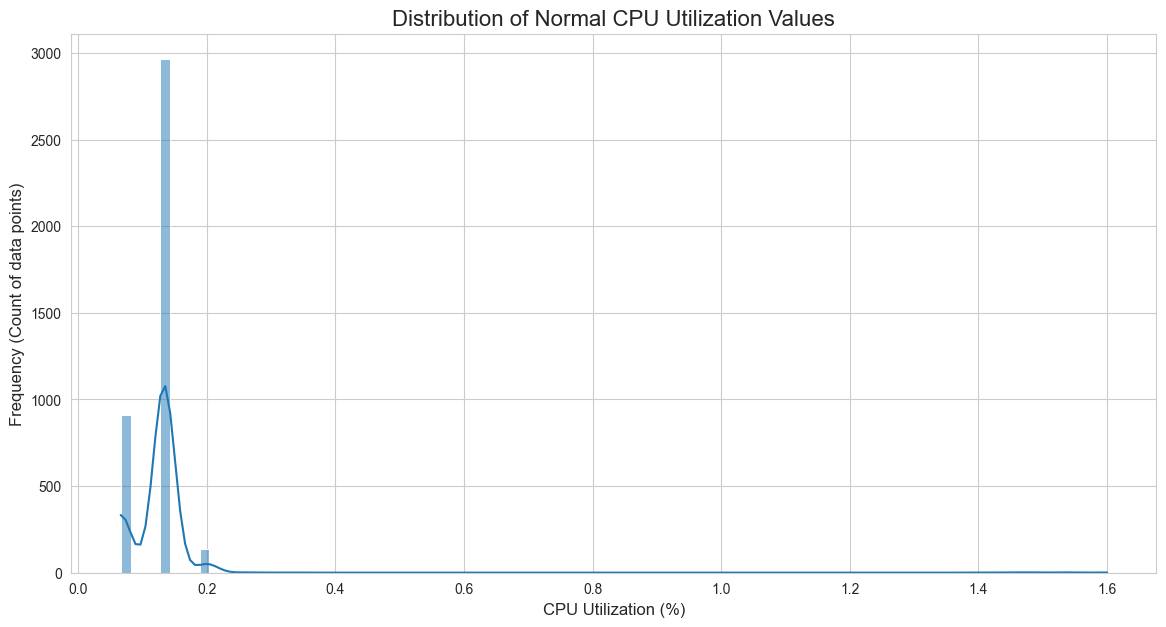

In [3]:
normal_data = df[df['is_anomaly'] == 0]

print("--- Descriptive Statistics for NORMAL data points ---")
display(normal_data['value'].describe())

plt.figure(figsize=(14, 7))
sns.histplot(normal_data['value'], bins=100, kde=True)
plt.title('Distribution of Normal CPU Utilization Values', fontsize=16)
plt.xlabel('CPU Utilization (%)', fontsize=12)
plt.ylabel('Frequency (Count of data points)', fontsize=12)
plt.grid(True)
plt.show()

## Feature Selection

For our baseline model, we will use the most direct feature available: the CPU utilization `value` itself. The `IsolationForest` algorithm is well-suited to handle this single feature to find points that are numerically distant from the majority.

In more complex models (like LSTMs or other deep learning approaches), we would perform feature engineering to create additional features, such as:
- Rolling averages (e.g., the average value over the last 10 minutes)
- Lagged values (e.g., the value from 5 minutes ago)

For now, keeping it simple allows us to establish a clear and interpretable baseline. We will create our feature matrix `X` (containing the input for the model) and our target vector `y_true` (containing the ground truth labels for evaluation).

In [4]:
# Select the feature(s) for the model
features = ['value']
X = df[features]

# This is our ground truth for evaluation later. The model itself does not use this for training.
y_true = df['is_anomaly']

print("Feature matrix X created.")
print(f"Shape of X: {X.shape}")
display(X.head())

Feature matrix X created.
Shape of X: (4032, 1)


,value
timestamp,
2014-02-14 14:30:00,0.132
2014-02-14 14:35:00,0.134
2014-02-14 14:40:00,0.134
2014-02-14 14:45:00,0.134
2014-02-14 14:50:00,0.134


## Model Training

Now we will train our `IsolationForest` model. Key points about the setup:

- **Unsupervised Nature**: `IsolationForest` is an unsupervised algorithm. This means we train it *only* on our feature matrix `X`. We do not show it the `y_true` labels during training. It learns the "shape" of normal data on its own.
- **`contamination`**: This is the most important hyperparameter. It tells the model the proportion of outliers it should expect in the dataset. Since we are in the unique position of having labels, we can set this value to the true proportion of anomalies in our data (`number of anomalies / total data points`). This gives our model a significant advantage.
- **`random_state`**: We set a `random_state` to ensure that the results are reproducible. Anyone running this notebook will get the exact same model output.

In [5]:
contamination_rate = y_true.sum() / len(y_true)
print(f"Calculated contamination rate: {contamination_rate:.6f}") 

# Initialize the IsolationForest model

model = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    random_state=42
)

# Train the model on our feature matrix X
print("\nTraining the Isolation Forest model...")
model.fit(X)
print("Model training complete.")

Calculated contamination rate: 0.000496

Training the Isolation Forest model...
Model training complete.


## Prediction and Evaluation

With our model now trained, we can use it to predict which data points are anomalies. The `IsolationForest` model provides a `predict()` method that returns:
- `1` for normal data points (inliers).
- `-1` for anomalous data points (outliers).

We will add these predictions to our DataFrame and then compare them against our `y_true` (the ground truth labels) to evaluate the model's performance. For easier comparison, we will map the model's output (`1` -> `0` for normal, `-1` -> `1` for anomaly) to match our `is_anomaly` column's format.

In [6]:
predictions = model.predict(X)


df['predicted_anomaly_raw'] = predictions

# Map the predictions to our 0/1 format for evaluation
# Normal (1) becomes 0, Anomaly (-1) becomes 1
df['predicted_anomaly'] = df['predicted_anomaly_raw'].map({1: 0, -1: 1})

print("Predictions have been generated.")
print("\nCounts of predicted labels:")
print(df['predicted_anomaly'].value_counts())

display(df[(df['is_anomaly'] == 1) | (df['predicted_anomaly'] == 1)])

Predictions have been generated.

Counts of predicted labels:
predicted_anomaly
0    4031
1       1
Name: count, dtype: int64


,value,is_anomaly,predicted_anomaly_raw,predicted_anomaly
timestamp,,,,
2014-02-26 22:05:00,2.344,1,-1,1
2014-02-27 17:15:00,0.602,1,1,0


### Performance Metrics

Now we will formally evaluate the model's performance using two standard methods from scikit-learn:

1.  **Classification Report**: This provides key metrics like precision, recall, and f1-score for each class.
    - **Precision**: Of all the points the model *predicted* as anomalies, how many were *actually* anomalies?
    - **Recall**: Of all the *actual* anomalies, how many did the model *find*?
    - **F1-Score**: The harmonic mean of precision and recall, a great single metric for overall performance.

2.  **Confusion Matrix**: This gives us a visual breakdown of the model's predictions versus the actual labels, showing True Positives, True Negatives, False Positives, and False Negatives.

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4030
           1       1.00      0.50      0.67         2

    accuracy                           1.00      4032
   macro avg       1.00      0.75      0.83      4032
weighted avg       1.00      1.00      1.00      4032


--- Confusion Matrix ---


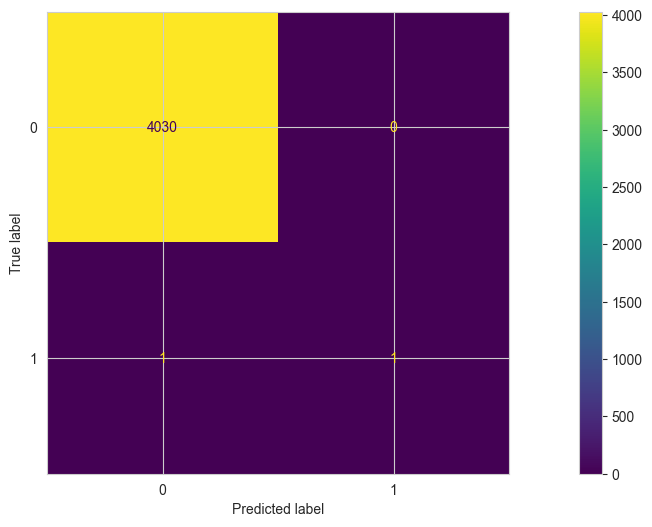

In [7]:
y_predicted = df['predicted_anomaly']

print("--- Classification Report ---")
print(classification_report(y_true, y_predicted))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Results Analysis and Interpretation

The evaluation metrics provide a clear picture of our baseline model's performance.

* **Precision (1.00):** The model has a perfect precision score for the anomaly class. This means that every single data point it flagged as an anomaly was, in fact, a true anomaly. It generated **zero False Positives**, which is an excellent result.

* **Recall (0.50):** The model's recall for the anomaly class is 0.50. This is the main area for improvement. It indicates that the model successfully identified only half (1 out of 2) of the true anomalies present in the dataset. The other true anomaly was misclassified as normal (a **False Negative**).

**Conclusion:** Our baseline `IsolationForest` model is highly **conservative** or **cautious**. When it raises an alarm, we can be very confident it's a real issue. However, its low sensitivity means it is prone to missing some anomalies.

For now, this baseline is sufficient. The immediate next step is to **serialize (save) this trained model** so it can be deployed.

## Model Serialization

The final step is to save our trained model to a file. This process, called serialization, allows us to load the model later for inference without needing to retrain it. We will use `joblib`, which is efficient for saving scikit-learn models.

In [8]:
model_filename = "isolation_forest_baseline_v1.joblib"
model_path = os.path.join(MODELS_DIR, model_filename)

joblib.dump(model, model_path)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: ..\models\isolation_forest_baseline_v1.joblib
